In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/data-3.csv", encoding='latin1', low_memory=False)

df.columns = df.columns.str.strip()

x = df['no2'].dropna().values

print("Data loaded successfully. Sample:", x[:5])

r = 102313045

# Compute parameters
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

# Transformation
z = x + a_r * np.sin(b_r * x)

# Normalize (important for GAN)
z = (z - np.mean(z)) / np.std(z)

print("a_r:", a_r, "b_r:", b_r)

Data loaded successfully. Sample: [17.4  7.  28.5 14.7  7.5]
a_r: 2.0 b_r: 0.6


In [3]:
print(df.columns)

Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


In [5]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)

# Convert data
z_real = torch.tensor(z, dtype=torch.float32).view(-1,1).to(device)

epochs = 2000
batch_size = 64

for epoch in range(epochs):
    idx = np.random.randint(0, z_real.size(0), batch_size)
    real_samples = z_real[idx]

    # Real labels = 1, Fake labels = 0
    real_labels = torch.ones((batch_size,1)).to(device)
    fake_labels = torch.zeros((batch_size,1)).to(device)

    # -------- Train Discriminator --------
    noise = torch.randn((batch_size,1)).to(device)
    fake_samples = G(noise)

    d_loss_real = criterion(D(real_samples), real_labels)
    d_loss_fake = criterion(D(fake_samples.detach()), fake_labels)

    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # -------- Train Generator --------
    noise = torch.randn((batch_size,1)).to(device)
    fake_samples = G(noise)

    g_loss = criterion(D(fake_samples), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 0 | D Loss: 1.3946 | G Loss: 0.7624
Epoch 200 | D Loss: 1.2572 | G Loss: 1.1046
Epoch 400 | D Loss: 1.1999 | G Loss: 0.7807
Epoch 600 | D Loss: 1.1569 | G Loss: 1.7550
Epoch 800 | D Loss: 1.2637 | G Loss: 0.8387
Epoch 1000 | D Loss: 1.3301 | G Loss: 0.6555
Epoch 1200 | D Loss: 1.3923 | G Loss: 0.6745
Epoch 1400 | D Loss: 1.3832 | G Loss: 0.7154
Epoch 1600 | D Loss: 1.3878 | G Loss: 0.6923
Epoch 1800 | D Loss: 1.3822 | G Loss: 0.7041


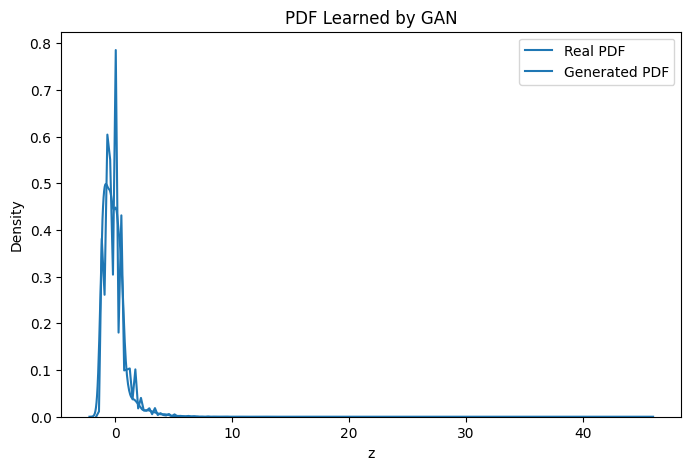

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Generate samples
noise = torch.randn((5000,1)).to(device)
z_fake = G(noise).detach().cpu().numpy()

# Plot PDF
plt.figure(figsize=(8,5))
sns.kdeplot(z, label="Real PDF")
sns.kdeplot(z_fake, label="Generated PDF")

plt.title("PDF Learned by GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()

# Save figure (IMPORTANT for submission)
plt.savefig("gan_pdf.png")

plt.show()

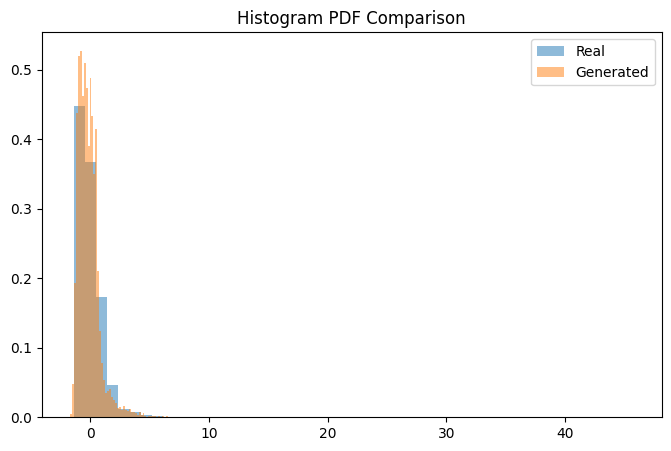

In [10]:
plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.5, label='Real')
plt.hist(z_fake, bins=50, density=True, alpha=0.5, label='Generated')

plt.legend()
plt.title("Histogram PDF Comparison")

plt.savefig("gan_histogram.png")
plt.show()